In [5]:
import os
import numpy as np

# Define the directories
input_dir = "/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/mitosis_patches_embeddings"

data = np.load(os.path.join(input_dir, 'clustering_all_features.npy'))

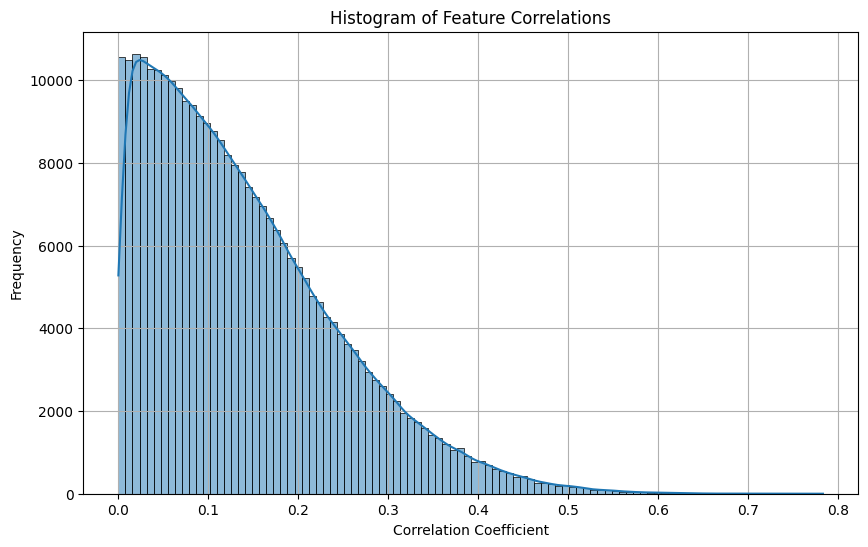

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Uniformly sample 1% of the data
sample_size = int(0.1 * data.shape[0])
sample_indices = np.random.choice(data.shape[0], size=sample_size, replace=False)
sampled_data = data[sample_indices, :]

# Step 2: Calculate pair-wise correlations
correlation_matrix = np.corrcoef(sampled_data, rowvar=False)

# Extract the upper triangle of the correlation matrix without the diagonal
upper_triangle_indices = np.triu_indices_from(correlation_matrix, k=1)
correlations = correlation_matrix[upper_triangle_indices]

# Step 3: Plot the histogram of correlations
plt.figure(figsize=(10, 6))
sns.histplot(np.abs(correlations), bins=100, kde=True)
plt.title('Histogram of Feature Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

# Step 4: Identify and remove highly correlated features
threshold = 0.5

# Create a mask to identify highly correlated features
highly_correlated_pairs = np.where(np.abs(correlations) > threshold)

# Create a set to hold the indices of columns to drop
columns_to_drop = set()

for i, j in zip(*upper_triangle_indices):
    if np.abs(correlation_matrix[i, j]) > threshold:
        columns_to_drop.add(j)  # or `i`, depending on your preference

# Get the list of columns to keep
all_columns = set(range(data.shape[1]))
columns_to_keep = list(all_columns - columns_to_drop)

# Extract the uncorrelated features
refined_data = data[:, columns_to_keep]
scaler = StandardScaler()
refined_data = scaler.fit_transform(refined_data)
# Step 5: Save the refined array to disk
np.save(input_dir+'/mitosis_patches_embeddings_uncorrelated_normalized.npy', refined_data)
np.save(input_dir+'/uncorrelated_columns_indices.npy', np.array(columns_to_keep))

print(f"Refined feature matrix saved with shape: {refined_data.shape}")

Refined feature matrix saved with shape: (5626571, 524)


In [6]:
# scaling the original data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
refined_data = scaler.fit_transform(data)

In [8]:
np.save(input_dir+'/mitosis_patches_embeddings_normalized.npy', refined_data)

In [9]:
# del sampled_data
del data

In [ ]:
# UNDERSAMPLING

import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Step 1: Cluster the dataset using MiniBatchKMeans with K=20
n_clusters = 20
batch_size = 10000  # You can adjust the batch size based on your memory capacity
minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42, n_init=3, verbose=1)
minibatch_kmeans.fit(refined_data)
labels = minibatch_kmeans.labels_

# Step 2: Identify the cluster with the minimum number of members
unique, counts = np.unique(labels, return_counts=True)
min_count = counts.min()

print(min_count)



In [16]:
from sklearn.utils import resample

min_count = 500 # counts.min()

# Step 3: Sample the same number of examples from each cluster
undersampled_data = []
undersampled_indices = []
for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    if len(cluster_indices) > min_count:
        sampled_indices = resample(cluster_indices, n_samples=min_count, random_state=42)
    else:
        sampled_indices = cluster_indices
    undersampled_data.append(refined_data[sampled_indices])
    undersampled_indices.extend(sampled_indices)

undersampled_data = np.vstack(undersampled_data)
undersampled_indices = np.array(undersampled_indices)
undersampled_labels = labels[undersampled_indices]

# undersampled_data now contains the undersampled and balanced dataset
print("Original dataset shape:", refined_data.shape)
print("Undersampled dataset shape:", undersampled_data.shape)

np.save(input_dir+'/mitosis_patches_embeddings_normalized_undersampled100.npy', undersampled_data)
np.save(input_dir+'/mitosis_patches_embeddings_normalized_undersampled100(indices).npy', undersampled_indices)

Original dataset shape: (5626571, 768)
Undersampled dataset shape: (10000, 768)


In [1]:
import numpy as np
input_dir = "/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/mitosis_patches_embeddings"
undersampled_data = np.load(input_dir+'/mitosis_patches_embeddings_uncorrelated_normalized_undersampled.npy')

done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19


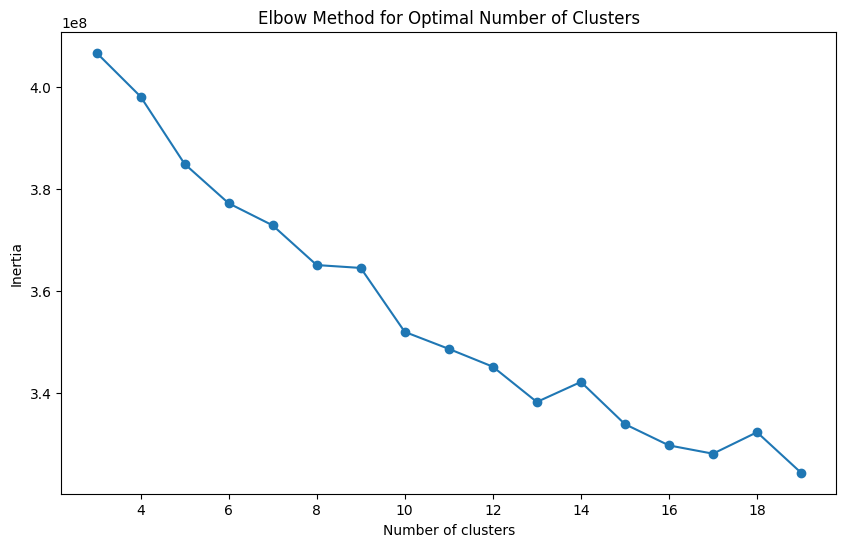

In [23]:
# FIND OPTIMAL NUMBER OF CLUSTERS

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

# Step 4: Determine the optimal number of clusters using Silhouette Score on undersampled data
batch_size = 50000  # You can adjust the batch size based on your memory capacity
range_n_clusters = range(3, 20)
silhouette_scores = []
inertia_values = []
for n_clusters in range_n_clusters:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42, n_init=10, verbose=0)
    cluster_labels = kmeans.fit_predict(undersampled_data)
    inertia_values.append(kmeans.inertia_)
    print(f"done {n_clusters}")

# Plot inertia values
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia_values, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# FIND OPTIMAL NUMBER OF CLUSTERS
from sklearn.cluster import KMeans
# Step 4: Determine the optimal number of clusters using Silhouette Score on undersampled data

range_n_clusters = range(1, 25)
inertia_values_c = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters,  random_state=42, n_init=3, verbose=0)
    kmeans = kmeans.fit(undersampled_data)
    inertia_values_c.append(kmeans.inertia_)
    print(f"done {n_clusters}")
    print(inertia_values_c)

# Plot inertia values
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia_values_c, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

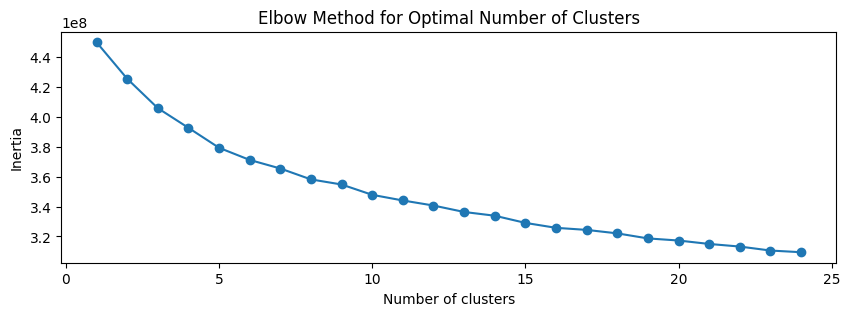

In [35]:
# Plot inertia values
range_n_clusters = range(1, 25)
plt.figure(figsize=(10, 3))
plt.plot(range_n_clusters, inertia_values_c, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [5]:
from sklearn.metrics import pairwise_distances

# Select a subset of the undersampled data
subset_size = min(100000, len(undersampled_data))  # Choose a subset size (e.g., 10000 or smaller)
subset_indices = np.random.choice(len(undersampled_data), size=subset_size, replace=False)
subset_data = undersampled_data[subset_indices]

pairwise_distances_matrix = pairwise_distances(subset_data, n_jobs=16, metric='cosine')

done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20


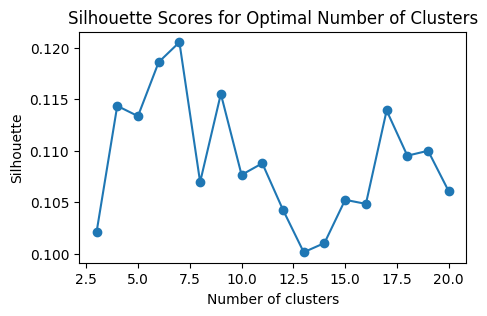

In [8]:
# Compute silhouette scores using precomputed distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = range(3, 21)
silhouette_scores_precomputed = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(subset_data)
    print(f"done {n_clusters} clustering")
    silhouette_avg = silhouette_score(pairwise_distances_matrix, cluster_labels, metric='precomputed')
    silhouette_scores_precomputed.append(silhouette_avg)
    print(f"silhouette_score: {silhouette_scores_precomputed}")

# Plot inertia values
plt.figure(figsize=(5, 3))
plt.plot(range_n_clusters, silhouette_scores_precomputed, marker='o')
plt.title("Silhouette Scores for Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette")
plt.show()

In [2]:
# Trying HDBSCAN
import numpy as np
input_dir = "/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/mitosis_patches_embeddings"
undersampled_data = np.load(input_dir+'/mitosis_patches_embeddings_uncorrelated_normalized_undersampled.npy')



In [4]:
import hdbscan
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)

In [120]:
undersampled_data = np.load("/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/clustering_experiments/test_features.npy")

In [95]:
directory = "/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/clustering_experiments/umap_dbscan_clustering_undersampled10000_all"
img_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

In [108]:
img_paths[5386].split("/")[-1]

'781_75292_53928.png'

In [105]:
np.sum(undersampled_data[:, 1]>0.4)

7324

In [131]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

undersampled_data = np.load("/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/clustering_experiments/test_features.npy")
nonzero_std_cols = np.where(np.std(undersampled_data, axis=0)>0.1)[0]
undersampled_data = undersampled_data[:, nonzero_std_cols]
scaler = MinMaxScaler()
undersampled_data = scaler.fit_transform(undersampled_data)
print("data processed")



data processed


/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


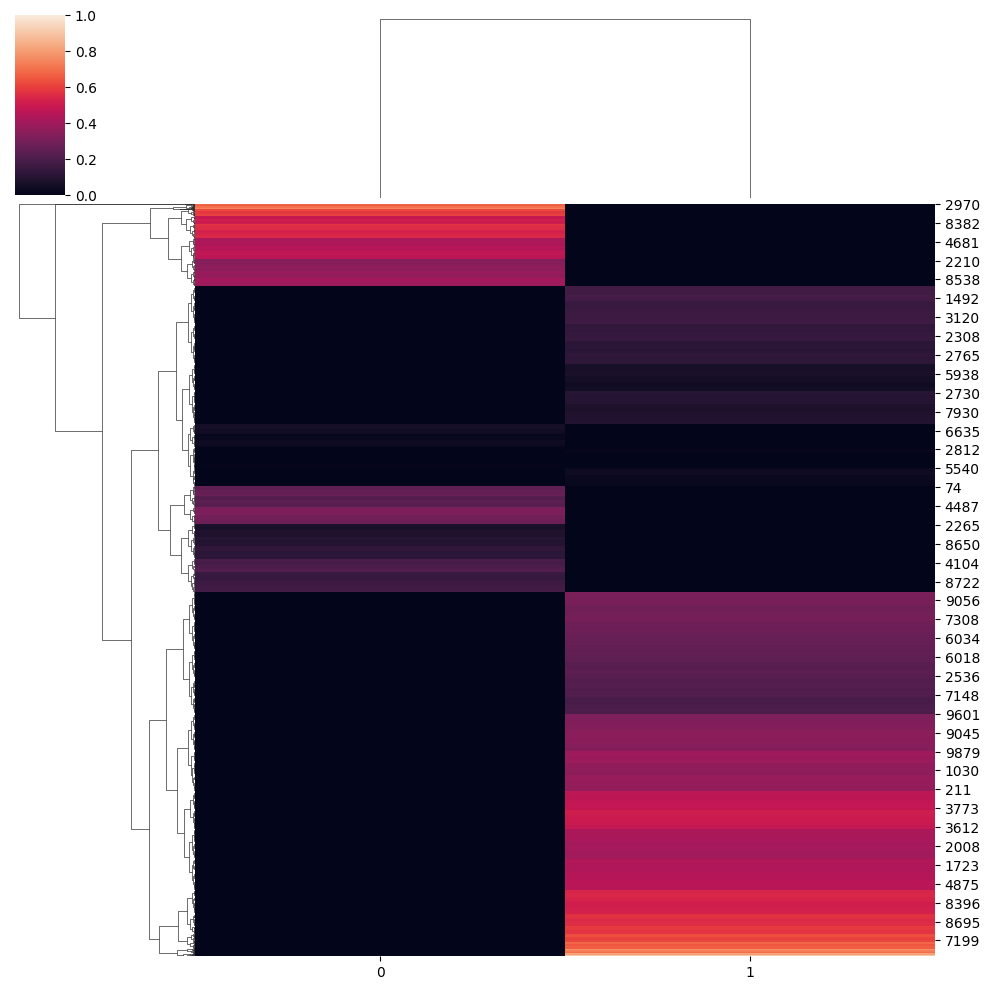

In [134]:
import seaborn as sns

sns.clustermap(undersampled_data[:, [0, 3]], method="centroid")

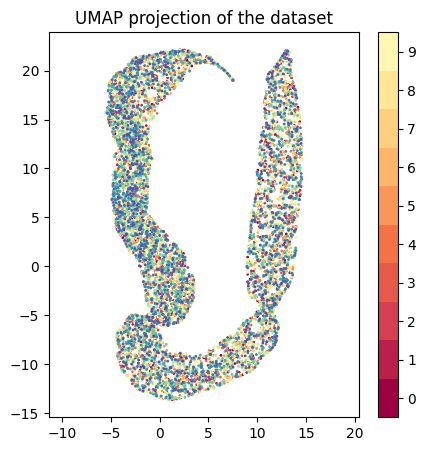

In [119]:
n_neighbors = 20
min_dist = 0.5
# Apply UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(undersampled_data)

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=undersampled_labels, cmap='Spectral', s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the dataset')
plt.show()

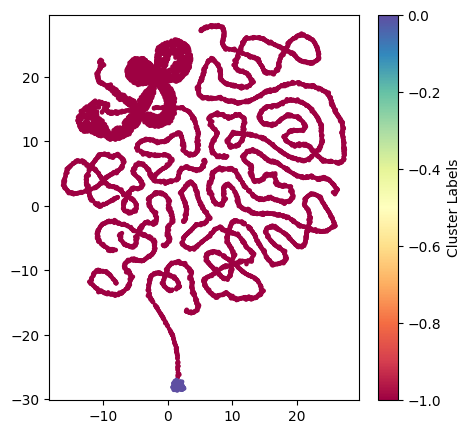

In [64]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering on UMAP embeddings
dbscan = DBSCAN(eps=0.7, min_samples=100).fit(embedding)

# Get cluster labels
cluster_labels = dbscan.labels_

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(label='Cluster Labels')
# plt.title('UMAP projection of the dataset with DBSCAN clustering', fontsize=24)
plt.show()


In [54]:
import shutil
from tqdm import tqdm
import pandas as pd

all_points = np.load(os.path.join(input_dir, 'clustering_all_points.npy'))
type_list = np.load(os.path.join(input_dir, 'clustering_all_type_list.npy'))
case_list = np.load(os.path.join(input_dir, 'clustering_all_case_list.npy'))
index_list = np.load(os.path.join(input_dir, 'clustering_all_index_list.npy'))
print("data loaded")
all_points = all_points[undersampled_indices]
type_list = type_list[undersampled_indices]
case_list = case_list[undersampled_indices]
index_list = index_list[undersampled_indices]

df = pd.DataFrame()
df['cluster'] = cluster_labels.tolist()
df['x'] = all_points[:, 0].tolist()
df['y'] = all_points[:, 1].tolist()
df['ins_ind'] = index_list.tolist()
df['type'] = type_list.tolist()
df['case'] = case_list.tolist()


root_dir = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/mitosis_patches'  # replace with your root directory
target_dir = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/clustering_experiments/umap_dbscan_clustering_undersampled10000_all'  # replace with your target directory

# Get unique clusters
clusters = df['cluster'].unique()

for cluster in clusters:
    n_samples = min(1000, np.sum(cluster_labels==cluster))
    # Sample 1000 instances from each cluster
    sample_df = df[df['cluster'] == cluster]#.sample(n=n_samples)
    sample_df["x"] = sample_df["x"].astype(int)
    sample_df["y"] = sample_df["y"].astype(int)
    # Create a new directory for this cluster
    cluster_dir = target_dir # os.path.join(target_dir, str(cluster))
    os.makedirs(cluster_dir, exist_ok=True)

    # Copy the images to the new directory
    for index, row in tqdm(sample_df.iterrows()):
        src_path = os.path.join(root_dir, row['type'], row['case'], f"{row['ins_ind']}_{row['x']}_{row['y']}.png")
        dst_path = os.path.join(cluster_dir, f"{row['ins_ind']}_{row['x']}_{row['y']}.png")
        shutil.copy(src_path, dst_path)


/tmp/ipykernel_2914630/4289336711.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["x"] = sample_df["x"].astype(int)
/tmp/ipykernel_2914630/4289336711.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["y"] = sample_df["y"].astype(int)


data loaded


1636it [00:13, 124.30it/s]
/tmp/ipykernel_2914630/4289336711.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["x"] = sample_df["x"].astype(int)
/tmp/ipykernel_2914630/4289336711.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["y"] = sample_df["y"].astype(int)
5737it [00:56, 102.37it/s]
/tmp/ipykernel_2914630/4289336711.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [60]:
nonzero_std_cols = np.where(np.std(undersampled_data, axis=0)!=0)[0]
nonzero_std_cols

array([ 3,  5, 17, 29, 35, 40, 48, 54, 59])